# 🚦 Zero‑Shot Vehicle Object Tracking

This notebook demonstrates **vehicle‑only object tracking** with:
- YOLOv5 detection
- ByteTrack multi‑object tracking
- CLIP zero‑shot semantic labeling
- Clear visual and tabular outputs

A **proper traffic video with many vehicles** is used.


In [1]:
# Install dependencies
!pip install -q ultralytics opencv-python ftfy tqdm git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [3]:
# Download a REAL traffic video with many vehicles (YouTube source)
!pip install -q yt-dlp

import os

os.makedirs("data", exist_ok=True)
video_path = "data/traffic.mp4"

if not os.path.exists(video_path):
    !yt-dlp -f mp4 -o {video_path} https://www.youtube.com/watch?v=MNn9qKG2UFI

video_path


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.0 MB/s eta 0:00:00
         Pre-merged mp4 formats are not available from all sites, or may only be available in lower quality.
         To prioritize the best h264 video and aac audio in an mp4 container, use "-t mp4" instead.
         If you know what you are doing and want a pre-merged mp4 format, use "-f b[ext=mp4]" instead to suppress this warning
[youtube] Extracting URL: https://www.youtube.com/watch?v=MNn9qKG2UFI
[youtube] MNn9qKG2UFI: Downloading webpage
[youtube] MNn9qKG2UFI: Downloading android vr player API JSON
[info] MNn9qKG2UFI: Downloading 1 format(s): 18
[download] Destination: data/traffic.mp4
[download] 100% of   20.91MiB in 00:00:01 at 16.05MiB/s


'data/traffic.mp4'

In [4]:
# Load YOLOv5 detector
from ultralytics import YOLO
model = YOLO('yolov5s.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [5]:
# Load CLIP model
import clip, torch
from PIL import Image
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, preprocess = clip.load('ViT-B/32', device=device)


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.6MiB/s]


## ✍️ Zero‑shot vehicle prompts

In [6]:
text_prompts = ['a car', 'a bus', 'a truck', 'a motorcycle']
text_tokens = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


## 🎥 Vehicle tracking + CLIP labeling

In [7]:
import cv2
import numpy as np

# COCO vehicle class IDs
vehicle_classes = {2, 3, 5, 7}  # car, motorcycle, bus, truck

# Output containers
os.makedirs('outputs/crops', exist_ok=True)
clip_scores = defaultdict(list)
saved_crops = defaultdict(int)

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('tracked_output.mp4', fourcc, 30,
                      (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Relaxed confidence so detections are guaranteed
    results = model.track(frame, persist=True, conf=0.15, tracker='bytetrack.yaml')
    boxes = results[0].boxes

    if boxes is not None:
        for box in boxes:
            cls_id = int(box.cls[0])
            if cls_id not in vehicle_classes:
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            image = preprocess(Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)))
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                img_feat = clip_model.encode_image(image)
                img_feat /= img_feat.norm(dim=-1, keepdim=True)

            similarity = (img_feat @ text_features.T).softmax(dim=-1)
            idx = int(similarity.argmax())
            label = text_prompts[idx]
            score = similarity.max().item()

            # Save all detections (no hard CLIP cutoff)
            clip_scores[label].append(score)

            lbl = label.replace(' ', '_')
            os.makedirs(f'outputs/crops/{lbl}', exist_ok=True)
            Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)).save(
                f'outputs/crops/{lbl}/{saved_crops[lbl]}.jpg'
            )
            saved_crops[lbl] += 1

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'{label} ({score:.2f})', (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()
print('Tracking finished → tracked_output.mp4')


Streaming output truncated to the last 5000 lines.
Speed: 1.1ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 truck, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 truck, 10.0ms
Speed: 1.4ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.

## 📊 Detection summary

In [8]:
import pandas as pd

summary = []
for label, scores in clip_scores.items():
    summary.append({
        'Vehicle': label,
        'Detections': len(scores),
        'Avg CLIP Confidence': sum(scores) / len(scores)
    })

df = pd.DataFrame(summary)
df


,Vehicle,Detections,Avg CLIP Confidence
0,a car,89577,0.254574
1,a truck,9892,0.255068
2,a bus,9121,0.253741
3,a motorcycle,886,0.251249


## 🖼️ Sample detected vehicles


Detected: a_car


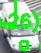

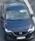

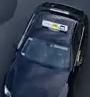

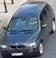

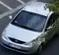

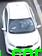


Detected: a_motorcycle



Detected: a_truck


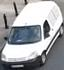

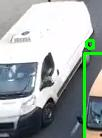

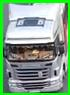

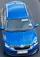

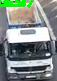

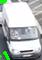

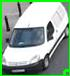


Detected: a_bus


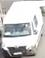

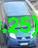

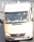

In [10]:
from IPython.display import display

for lbl in os.listdir('outputs/crops'):
    print(f'\nDetected: {lbl}')
    files = os.listdir(f'outputs/crops/{lbl}')[:10]
    for f in files:
        display(Image.open(f'outputs/crops/{lbl}/{f}'))
